# DVD Inversion exercise (GNSS- Low Noise)

This is the noteboook that solves the inversion exercise using just GNSS dataset

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Gnss
from vmod.source import Mctigue
from vmod.inverse import Inverse

## Read dataset

In [2]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xs,ys,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xs*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xs))]

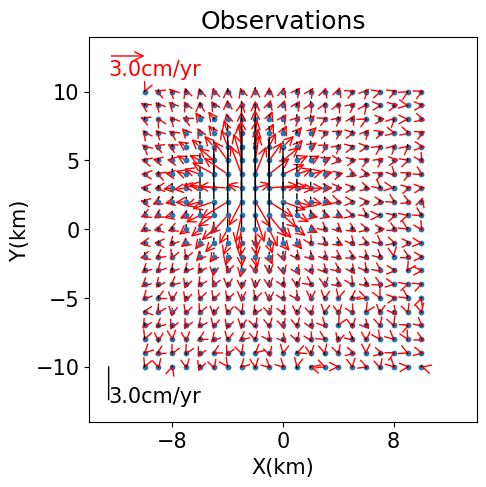

In [3]:
plt.rcParams.update({'font.size': 15})
util.plot_gnss(xs,ys,uxs,uys,uzs,title='Observations',scl=3.0,figsize=(5,5))

## Create data object

In [4]:
obs=Gnss()

obs.add_names(names)

obs.add_xs(xs)
obs.add_ys(ys)
obs.add_zs(xs*0)

obs.add_ux(uxs)
obs.add_uy(uys)
obs.add_uz(uzs)

obs.add_errx(euxs)
obs.add_erry(euys)
obs.add_errz(euzs)

#obs.importcsv('examples/gps/fisher_gnss.txt')

## Create Model object

In [5]:
mct = Mctigue(obs)
uxsm,uysm,uzsm=mct.forward([0,0,2.0e3,5e2,0.003],unravel=False)

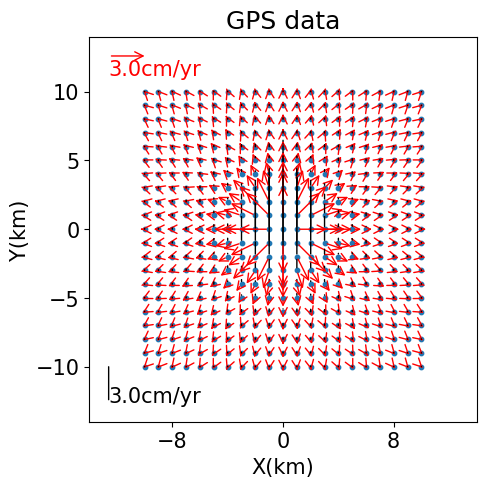

In [6]:
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=3.0,figsize=(5,5))

## Create Inversion object

In [7]:
#Bounds for parameters
mct.set_bounds(low_bounds = [-10000,-10000,5e2,1e1,0.0001], high_bounds = [10000,10000,1e4,5e3,0.01])

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares Inversion

In [8]:
params=inv.nlsq()

parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,params[i])

100%|██████████| 64/64 [00:10<00:00,  6.05it/s]

xcen -2517.048013056409
ycen 2872.867081308479
depth 2184.4604996554526
radius 1014.5191286104954
dP 0.00038836395415695583


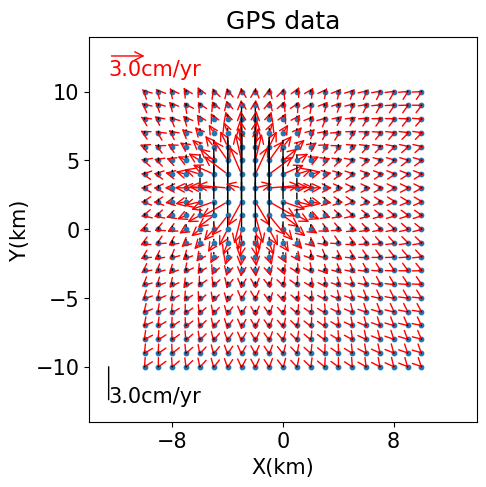

In [9]:
uxsm,uysm,uzsm=mct.forward(params,unravel=False)

util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=3.0,figsize=(5,5))

## Bayesian Inversion

In [11]:
trace=inv.mcmc_em('gnss_low_emcee')

[np.float64(-2.5170480134725346), np.float64(2.872867081073607), np.float64(2.1844604927143845), np.float64(10.145191005173082), np.float64(0.3883639864875223), 0.0]


100%|██████████| 91666/91666 [39:16<00:00, 38.90it/s]


In [10]:
import pickle
with open('gnss_low_emcee.pkl', 'rb') as f:
    data = pickle.load(f)

trace=[]
for key in data.keys():
    trace.append(data[key])

In [11]:
traces=np.copy(trace)
np.save('traces.npy',traces)
data=traces

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_62825/1445688330.py:9: SyntaxWarning: invalid escape sequence '\m'
  labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(m\mu)$']


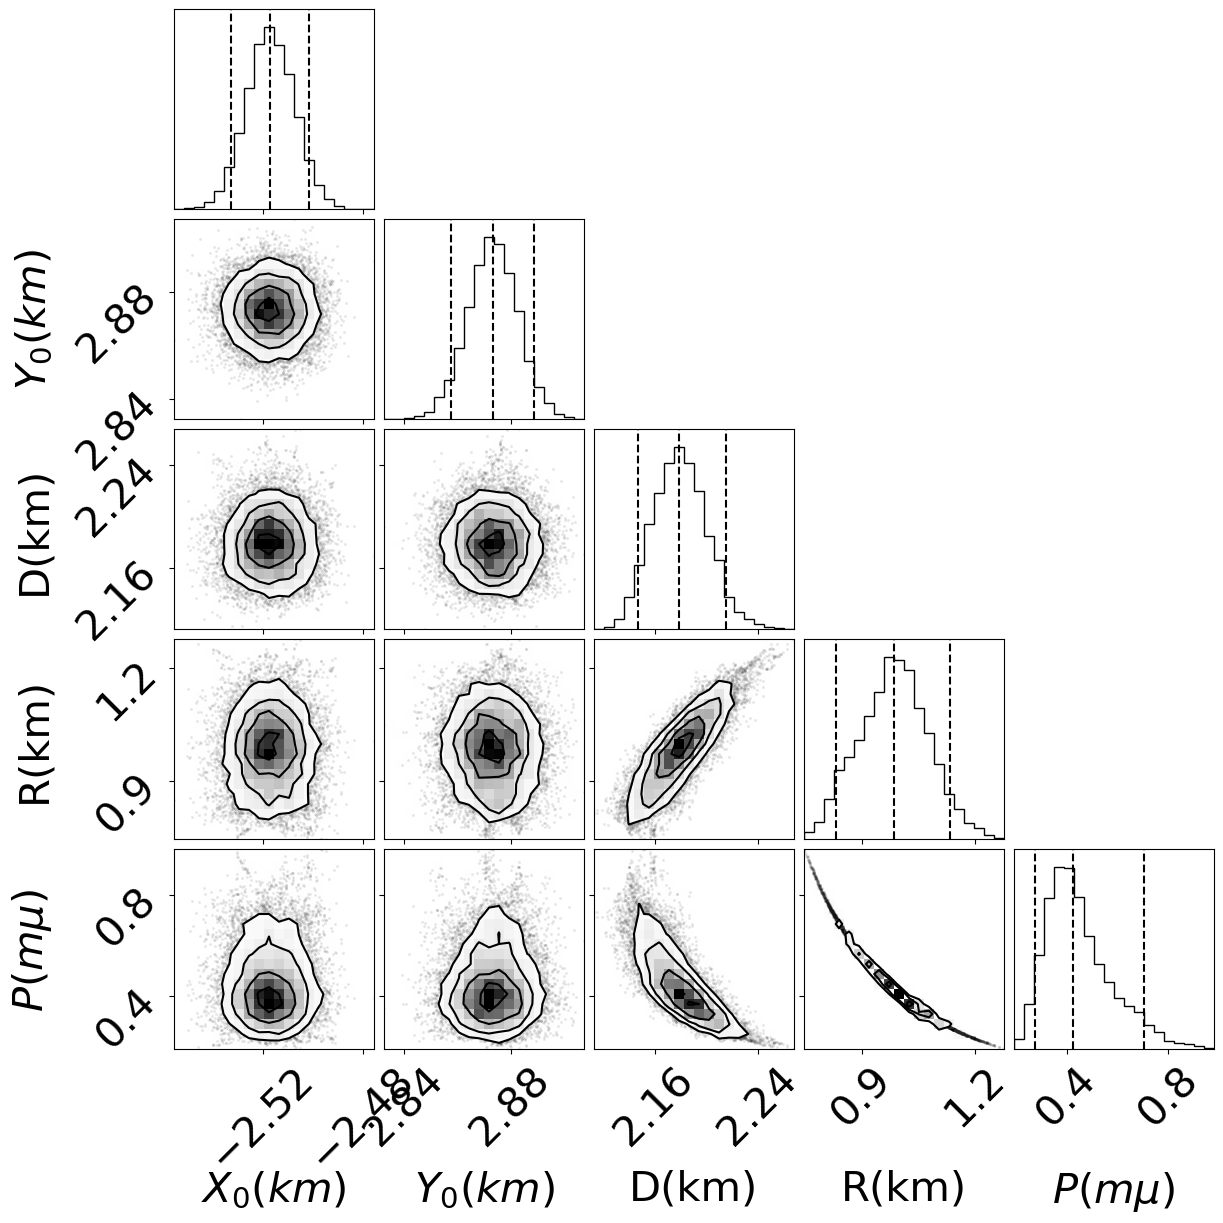

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]*1e3
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$P(m\mu)$']

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

## Forward model for the median solution

[-2.51695790e+03  2.87313722e+03  2.17927860e+03  9.85217964e+02
  4.24331030e-04]


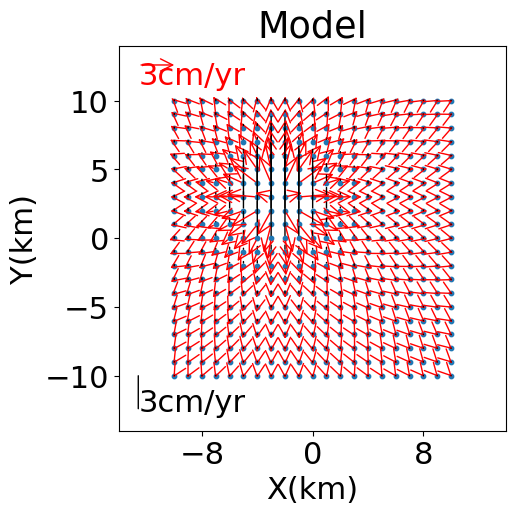

In [15]:
xbest=np.array([np.median(data[0,:])*1e3,np.median(data[1,:])*1e3,np.median(data[2,:])*1e3,np.median(data[3,:])*1e3,np.median(data[4,:]/1e3)])
print(xbest)
uxsm,uysm,uzsm=mct.forward(xbest,unravel=False)
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,title='Model',scl=3,figsize=(5,5))

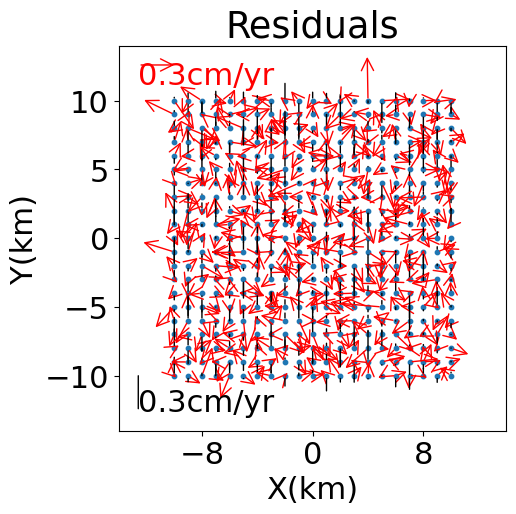

In [16]:
util.plot_gnss(xs,ys,uxs-uxsm,uys-uysm,uzs-uzsm,title='Residuals',scl=0.3,figsize=(5,5))